<a href="https://colab.research.google.com/github/aviMitra/EVA5/blob/main/Assignment%206/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [16]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image

In [17]:
# Ghost Normalization
class GBN(nn.Module):
  def __init__(self, num_features, groups, eps=1e-05):
    super(GBN, self).__init__()
    self.num_features = num_features
    self.eps = eps
    self.groups = groups

  def forward(self, X):
    """
    X: Input Tensor with (M, C, F) dimensions
    groupsM: Number of groups for the mini-batch dimension
    eps: A small value to prevent division by zero
    """
    # Split the mini-batch dimension into groups of smaller batches
    M, C, x, y = X.shape
    X = X.reshape(self.groups, -1, C, x, y)
    # Calculate statistics over dim(0) x dim(2) number
    # of slices of dim(1) x dim(3) dimension each
    mean = X.mean([1, 3], keepdim=True)
    var = X.var([1, 3], unbiased=False, keepdim=True)
    # Normalize X
    X = (X - mean) / (torch.sqrt(var + self.eps))
    # Reshape into the initial tensor shape
    X = X.reshape(M, C, x, y)
    return X
  

In [18]:
def conv_block(in_channels, out_channels, kernel_size=(3,3), **kwargs):

    batch_normalize = nn.ModuleDict([
                ['BN', nn.BatchNorm2d(out_channels)],
                ['GBN', GBN(out_channels, 10)],
                ['None', None]])

    activations = nn.ModuleDict([
                ['Relu', nn.ReLU()],
                ['None', None]])

    blocks = [layer for layer in [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False), 
                                       nn.Dropout(kwargs['dropout']), 
                                       batch_normalize[kwargs['batch_norm']], 
                                       activations[kwargs['activation']]] if layer]
    return nn.Sequential(*blocks)

def transition_block(in_channels, out_channels, kernel_size=(1, 1), **kwargs):
    blocks = [nn.MaxPool2d(2, 2), conv_block(in_channels, out_channels, kernel_size=kernel_size, **kwargs)]
    return nn.Sequential(*blocks)

def output_block(kernel_size, *args, **kwargs):
   return nn.Sequential(nn.AvgPool2d(kernel_size=kernel_size))



In [19]:
class Net(nn.Module):
    def __init__(self, **kwargs):
        super(Net, self).__init__()

        # Structure
        structure = [('conv',1, 10), 
                     ('conv',10, 10), 
                     ('conv', 10, 10), 
                     ('transition', 10, 10), 
                     ('conv', 10, 10), 
                     ('conv', 10, 10), 
                     ('conv', 10, 20),
                     ('conv', 20, 10),
                     ('out', 3, 0)]

        layers = {'conv': conv_block, 
                  'transition': transition_block, 
                  'out': output_block}
        
        blocks = [layers[ltype](in_f, out_f, **kwargs) 
                       for ltype, in_f, out_f in structure]
        
        self.model = nn.Sequential(*blocks)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [20]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [21]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [22]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=100, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=100)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [23]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(dropout=0, batch_norm='BN', activation='Relu').to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
           Dropout-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
           Dropout-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             900
          Dropout-10           [-1, 10, 22, 22]               0
      BatchNorm2d-11           [-1, 10, 22, 22]              20
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [24]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, optim):
  model.train()
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    if optim in ['L1', 'L12']:
      lambda_l1 = 0.001
      loss = mse(y_pred, target)
      l1 = 0
      for p in model.Parameters():
        l1 += p.abs().sum()
      loss += lambda_l1 * l1
    else: 
      loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    description = 'Loss={:.4f} Batch_id={} Accuracy={:.2f}'.format(loss.item(), batch_idx, 100*correct/processed)
    train_acc.append(100*correct/processed)
  print(description)

def test(model, device, test_loader, label):
    mis_count = 25
    model.eval()
    test_loss = 0
    correct = 0
    misclassified = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            if label == 'with GBN' and mis_count:
              for d, p, t in zip(data, pred, target):
                 if p != t: 
                     misclassified.append((d, p, t))
                     mis_count -= 1
                
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss, 100. * correct / len(test_loader.dataset), misclassified

# Let's Train and test our model

In [29]:
def train_and_test(model, label, opti='L1', epochs=25):
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  if opti == 'L2':
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, dampening=0,weight_decay=0.001,nesterov=False)
  elif opti == 'L12':
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, dampening=0,weight_decay=0.001,nesterov=False)
      
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2)
  
  losses = []
  accuracies = []
  for epoch in range(epochs):
      print("EPOCH:", int(epoch+1))
      print('Learning rate: ', optimizer.param_groups[0]['lr'])
      train(model, device, train_loader, optimizer, epoch, optim)
      loss, accuracy, misclassified = test(model, device, test_loader, label)
      scheduler.step(loss)
      losses.append(loss)
      accuracies.append(accuracy)
  return losses, accuracies, misclassified

In [30]:
EPOCH = 25
models = [Net(dropout=0, batch_norm='BN', activation='Relu').to(device), 
          Net(dropout=0, batch_norm='BN', activation='Relu').to(device),
          Net(dropout=0, batch_norm='BN', activation='Relu').to(device),
          Net(dropout=0, batch_norm='GBN', activation='Relu').to(device),
          Net(dropout=0, batch_norm='GBN', activation='Relu').to(device)]

optimizers = ['L1', 'L2', 'L12', None, 'L12']
labels = ['with L1 + BN',
          'with L2 + BN',
          'with L1 and L2 with BN',
          'with GBN',
          'with L1 and L2 with GBN']
all_losses = []
all_accuracies = []
all_missed = []

for model, optimizer, label in zip(models, optimizers, labels):
  print('----------------------- Model -> ', label, '-------------------------------------------')
  losses, accuracies, misclassified = train_and_test(model=model, label=label, opti=optimizer, epochs=EPOCH)
  all_losses.append(losses)
  all_accuracies.append(accuracies)
  all_missed.append(misclassified)

----------------------- Model ->  with L1 + BN -------------------------------------------
EPOCH: 1
Learning rate:  0.1
Loss=0.0698 Batch_id=599 Accuracy=95.79

Test set: Average loss: 0.0461, Accuracy: 9851/10000 (98.51%)

EPOCH: 2
Learning rate:  0.1
Loss=0.0900 Batch_id=599 Accuracy=98.17

Test set: Average loss: 0.0440, Accuracy: 9863/10000 (98.63%)

EPOCH: 3
Learning rate:  0.1
Loss=0.0148 Batch_id=599 Accuracy=98.40

Test set: Average loss: 0.0257, Accuracy: 9928/10000 (99.28%)

EPOCH: 4
Learning rate:  0.1
Loss=0.0265 Batch_id=599 Accuracy=98.58

Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

EPOCH: 5
Learning rate:  0.1
Loss=0.0159 Batch_id=599 Accuracy=98.79

Test set: Average loss: 0.0287, Accuracy: 9903/10000 (99.03%)

EPOCH: 6
Learning rate:  0.1
Loss=0.1126 Batch_id=599 Accuracy=98.80

Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

EPOCH: 7
Learning rate:  0.1
Loss=0.0209 Batch_id=599 Accuracy=98.88

Test set: Average loss: 0.0248, Accuracy:

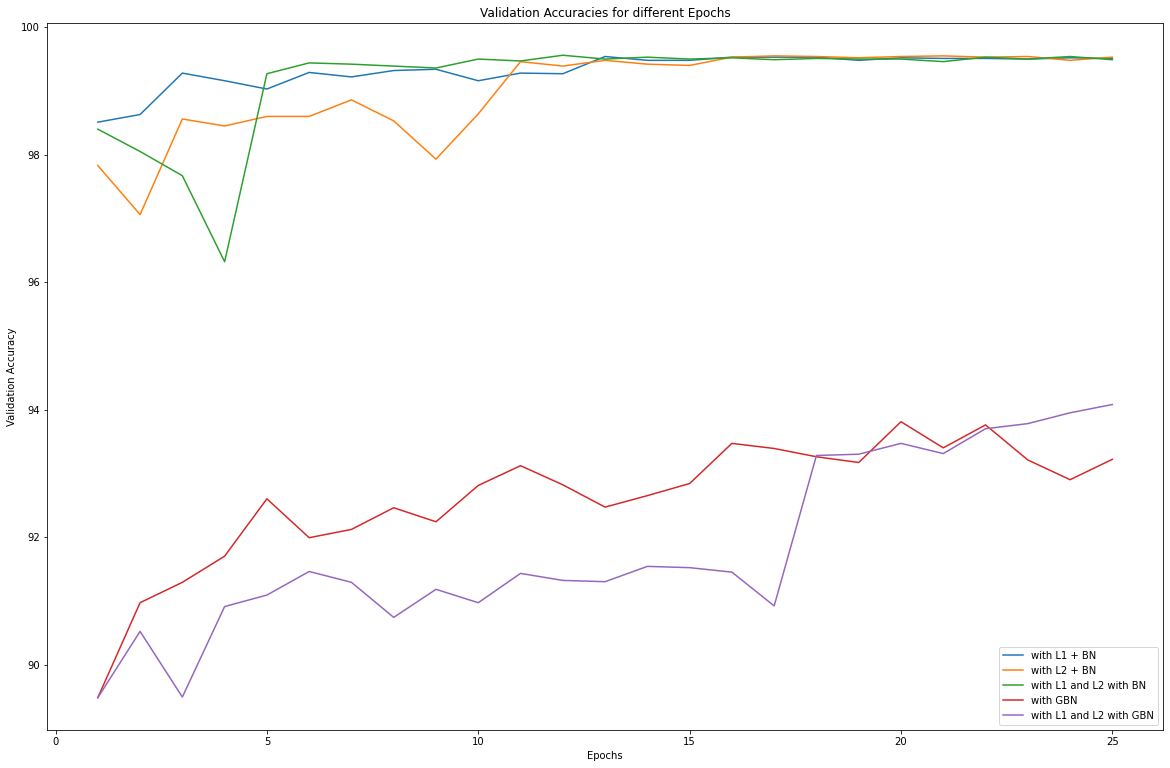

In [31]:
# One plot to show them all
import matplotlib.pyplot as plt
x = list(range(EPOCH+1))[1:]
plt.figure(figsize=(20,13)) 
for loss, label in zip(all_accuracies, labels):
    plt.plot(x, loss, label = label)

plt.xlabel('Epochs')
# Set the y axis label of the current axis.
plt.ylabel('Validation Accuracy')
# Set a title of the current axes.
plt.title('Validation Accuracies for different Epochs')
# show a legend on the plot
plt.legend()
# Display a figure.

plt.show()

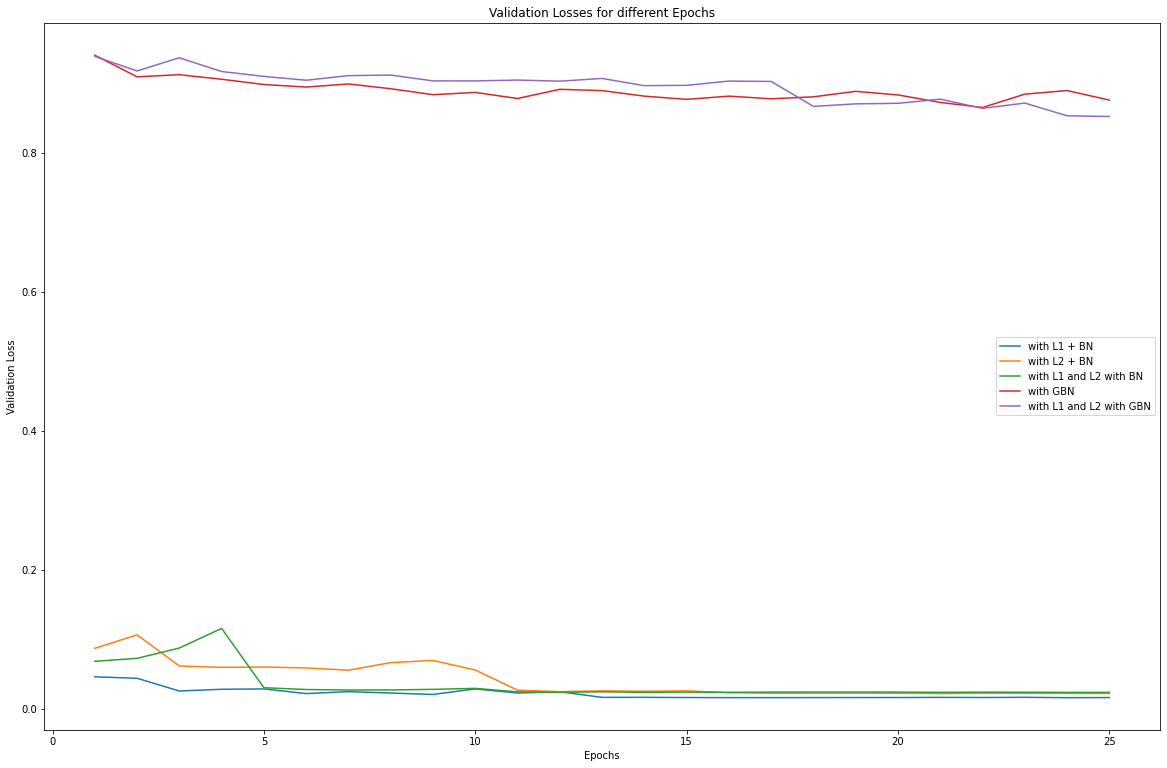

In [32]:
# One plot to show them all
import matplotlib.pyplot as plt
x = list(range(EPOCH+1))[1:]
plt.figure(figsize=(20,13)) 
for loss, label in zip(all_losses, labels):
    plt.plot(x, loss, label = label)

plt.xlabel('Epochs')
# Set the y axis label of the current axis.
plt.ylabel('Validation Loss')
# Set a title of the current axes.
plt.title('Validation Losses for different Epochs')
# show a legend on the plot
plt.legend()
# Display a figure.

plt.show()

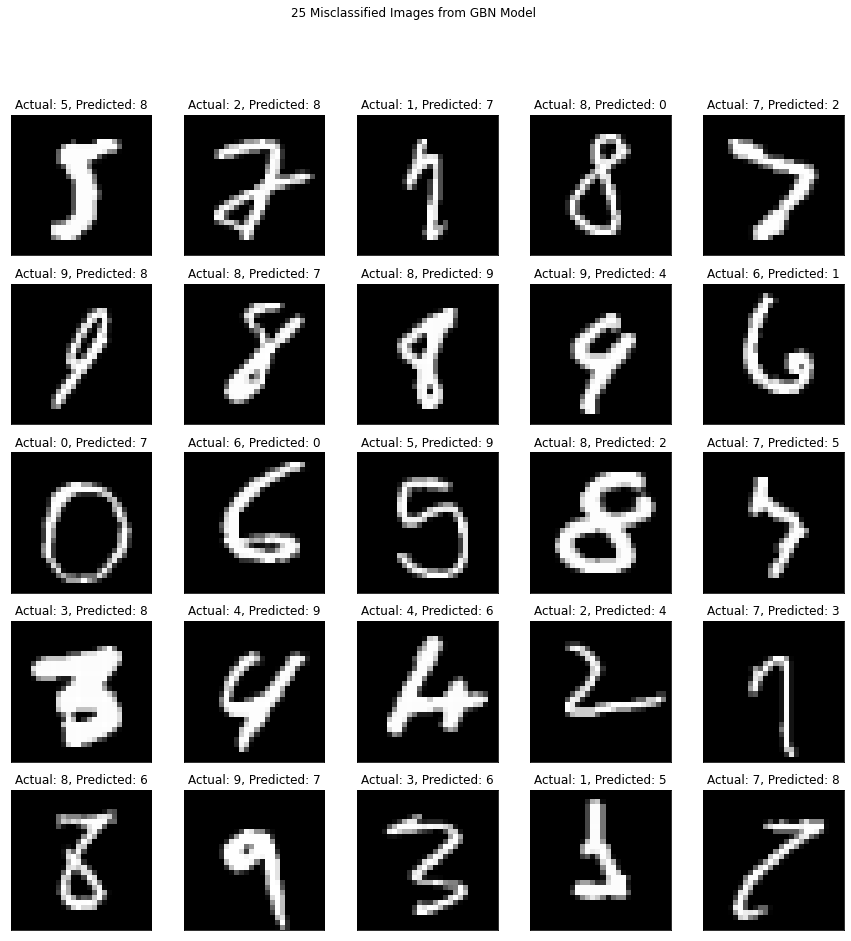

In [33]:
# 25 Misclassified Images

image_idx = []


plt.figure(figsize=(15,15))
missed  = all_missed[3]
plt.suptitle('25 Misclassified Images from GBN Model')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Actual: {}, Predicted: {}'.format(str(missed[i][2].item()), missed[i][1].item()))
    plt.imshow(missed[i][0].cpu().squeeze(), cmap='gray')

plt.show()
